# Bipartite Graphs

In [34]:
list_of_ingredients = [1,2,3,4]
list_of_recipes = ['r1','r2','r3']
list_of_users = [1,2,3]

### Ingredient-Recipe Graph

In [35]:
import networkx as nx

ingredient_recipe = nx.Graph()
ingredient_recipe.add_nodes_from(list_of_ingredients, bipartite='ingredients')
ingredient_recipe.add_nodes_from(list_of_recipes, bipartite='recipes')

In [36]:
ing_rec_edges = [(1, "r1"), (1, "r3"), (2, "r1"), (2, "r2"), (3, "r2"), (3, "r3"), (4, "r2")]
ingredient_recipe.add_edges_from(ing_rec_edges)

In [37]:
ing_rec_pos = nx.bipartite_layout(ingredient_recipe,list_of_ingredients)

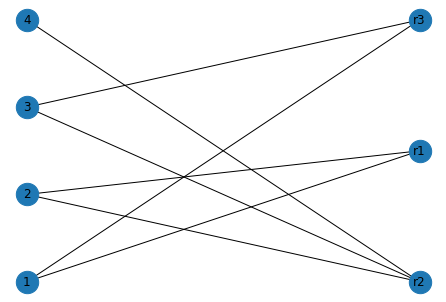

In [38]:
nx.draw(ingredient_recipe,ing_rec_pos, with_labels=1,node_size=500)

### Recipe-User

In [39]:
recipe_user = nx.Graph()
recipe_user.add_nodes_from(list_of_recipes, bipartite='recipes')
recipe_user.add_nodes_from(list_of_users, bipartite='users')

In [40]:
rec_usr_edges = [(1, "r1",5), (1, "r2", 4), (1, "r3", 4), (2, "r1",3), (2, "r2",5), (3, "r3",2)]
recipe_user.add_weighted_edges_from(rec_usr_edges)

In [41]:
rec_usr_pos = nx.bipartite_layout(recipe_user,list_of_recipes)

{('r1', 1): Text(0.0, -0.375, '5'),
 ('r1', 2): Text(0.0, 0.0, '3'),
 ('r2', 1): Text(0.0, -0.75, '4'),
 ('r2', 2): Text(0.0, -0.375, '5'),
 ('r3', 1): Text(0.0, 0.0, '4'),
 ('r3', 3): Text(0.0, 0.75, '2')}

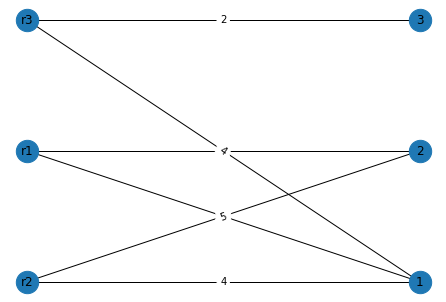

In [42]:
nx.draw(recipe_user,rec_usr_pos, with_labels=1,node_size=500)
edge_labels = nx.get_edge_attributes(recipe_user, "weight")
nx.draw_networkx_edge_labels(recipe_user, rec_usr_pos, edge_labels)

# Shallow Encoding of Ingredients

In [43]:
import numpy as np
I = np.array(list_of_ingredients)

B = ((I.reshape(-1,1) & (2**np.arange(len(list_of_ingredients).bit_length()))) != 0).astype(int)
ingredient_embeddings_matrix = B[:,::-1]
print(ingredient_embeddings_matrix)

[[0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]]


# GraphSAGE

### Recipe Vectors

In [44]:
recipe_vectors = []
target_user = 1
target_recipe = 'r3'
weight_matrix_W1 = np.random.random((len(ingredient_embeddings_matrix[0]),len(ingredient_embeddings_matrix[0])+2))

for recipe in list(recipe_user.neighbors(target_user)):
    if recipe != target_recipe:
        result = [[0.0]*1]*len(ingredient_embeddings_matrix[0])
        result = np.array(result)
        recipe_vector = []
        AGG = np.array([0]*len(list_of_ingredients).bit_length())
        Mean = 0
        
        for ingredient in list(ingredient_recipe.neighbors(recipe)):
            AGG += ingredient_embeddings_matrix[ingredient-1]
            
        for user in list(recipe_user.neighbors(recipe)):
            Mean += recipe_user[user][recipe]['weight']
            
        AGG = AGG/len(list(ingredient_recipe.neighbors(recipe)))
        Mean /= len(list(recipe_user.neighbors(recipe)))

        CONCAT = list(AGG)
        CONCAT.append(recipe_user[target_user][recipe]['weight'])
        CONCAT.append(Mean)
        recipe_vector = CONCAT
        
        arr = np.array(recipe_vector)
        recipe_vec = []
        recipe_vec.append(arr)
        recipe_vec = np.array(recipe_vec)
        recipe_vec = recipe_vec.transpose()
        for i in range(len(weight_matrix_W1)):
            for j in range(len(recipe_vec[0])):
                for k in range(len(recipe_vec)):
                    result[i][j] += weight_matrix_W1[i][k] * recipe_vec[k][j]
#         result = list(result.transpose()[0])            
        sig = 1 / (1 + np.exp(-result))
        #recipe_vector.append(recipe_user[target_user][recipe]['weight'])
        #recipe_vector.append(Mean)
        recipe_vectors.append(list(sig.transpose()[0]))

In [45]:
recipe_vectors

[[0.919295054004257, 0.9955385798214681, 0.9984663054477015],
 [0.9130508680403482, 0.9931977429318285, 0.9973920717917556]]

### Personalization Vector

In [46]:
personalization_vector = []
agg_recipe_vectors = np.array(recipe_vectors[0])
weight_matrix_W2 = np.random.random((len(recipe_vectors[0]),len(recipe_vectors[0])))
result = [[0.0]*1]*len(recipe_vectors[0])
result = np.array(result)

for i in range(len(recipe_vectors)):
    if i!= 0:
        agg_recipe_vectors += np.array(recipe_vectors[i])

agg_recipe_vectors /= len(recipe_vectors)

arr = np.array(agg_recipe_vectors)
recipe_vec = []
recipe_vec.append(arr)
recipe_vec = np.array(recipe_vec)
recipe_vec = recipe_vec.transpose()
for i in range(len(weight_matrix_W2)):
    for j in range(len(recipe_vec[0])):
        for k in range(len(recipe_vec)):
            result[i][j] += weight_matrix_W2[i][k] * recipe_vec[k][j]
#         result = list(result.transpose()[0])            
sig = 1 / (1 + np.exp(-result))

personalization_vector.append(list(sig.transpose()[0]))

In [47]:
personalization_vector = personalization_vector[0]

In [48]:
personalization_vector

[0.634738599479793, 0.6709886628758633, 0.747103149501061]

### Prediction

In [49]:
prediction = []
AGG = np.array([0]*len(list_of_ingredients).bit_length())
Mean = 0
weight_matrix_W3 = np.random.random((1,len(personalization_vector)*2+1))
result = [[0.0]*1]*1
result = np.array(result)

for ingredient in list(ingredient_recipe.neighbors(target_recipe)):
    AGG += ingredient_embeddings_matrix[ingredient-1]
for user in list(recipe_user.neighbors(recipe)):
    if user != target_user:
        Mean += recipe_user[user][recipe]['weight']

AGG = AGG/len(list(ingredient_recipe.neighbors(target_recipe)))   
target_recipe_users = list(recipe_user.neighbors(target_recipe))
target_recipe_users.remove(target_user)
Mean /= len(target_recipe_users)

CONCAT = list(AGG)
for element in personalization_vector:
    CONCAT.append(element)
CONCAT.append(Mean)
recipe_vector = CONCAT
        
arr = np.array(recipe_vector)
recipe_vec = []
recipe_vec.append(arr)
recipe_vec = np.array(recipe_vec)
recipe_vec = recipe_vec.transpose()
for i in range(len(weight_matrix_W3)):
    for j in range(len(recipe_vec[0])):
        for k in range(len(recipe_vec)):
            result[i][j] += weight_matrix_W3[i][k] * recipe_vec[k][j]
#         result = list(result.transpose()[0])            
sig = 1 / (1 + np.exp(-result))



prediction.append(list(sig.transpose()[0]))

In [50]:
prediction

[[0.971832089238135]]

In [55]:
round(prediction[0][0]*5,2)

4.86